Script to perform hyperparameter optimisation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import pickle
import joblib

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]

In [2]:
dfpre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7453 entries, 0 to 7995
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Time                                  7453 non-null   datetime64[ns]
 1   LON                                   7453 non-null   float64       
 2   LAT                                   7453 non-null   float64       
 3   Eastward wind                         7453 non-null   float64       
 4   Northward wind                        7453 non-null   float64       
 5   Temperature above oceans              7453 non-null   float64       
 6   Air density above oceans              7337 non-null   float64       
 7   Max wave height                       6274 non-null   float64       
 8   Swell direction                       6274 non-null   float64       
 9   Wind wave direction                   6274 non-null   float64       
 10  

In [3]:
dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.head(n=5)

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
0,2.267688,6.741482,0.113690,0.044994,0.0,358.9
1,1.782681,6.410275,0.113690,0.044994,0.0,358.9
2,1.154659,6.385135,0.083984,0.054000,0.0,358.9
3,0.348801,6.094659,0.083984,0.054000,0.0,358.9
4,-0.593128,6.153186,0.083984,0.054000,0.0,358.9


In [4]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [5]:
x_pre = imputer.transform(dfpre)

In [6]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [7]:
# Calculate the True North wind direction

condwind = [(dfpre['eastwind']>0) & (dfpre['northwind']<0),
            (dfpre['eastwind']<0) & (dfpre['northwind']>0),
            (dfpre['eastwind']>0) & (dfpre['northwind']>0)]

choicewind = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"])))]

dfpre["True North Wind Direction"] = np.select(condwind, choicewind, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))))

In [8]:
# Calculate the True North current direction

condcurr = [(dfpre['eastcurrent']<0) & (dfpre['northcurrent']>0),
            (dfpre['eastcurrent']>0) & (dfpre['northcurrent']<0),
            (dfpre['eastcurrent']<0) & (dfpre['northcurrent']<0)]

choicecurr = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"])))]

dfpre["True North Current Direction"] = np.select(condcurr, choicecurr, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))))

In [9]:
dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [10]:
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog,True North Wind Direction,True North Current Direction,Current Speed,Wind Speed
count,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.019228,0.004214,8.870751,242.699284,198.585961,150.634332,0.096788,6.513813
std,5.296850,4.429899,0.089903,0.074041,8.619512,108.555287,92.310964,100.306234,0.067697,3.048934
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,0.052191,0.102997,0.000735,0.193221
25%,-1.756650,-2.534061,-0.021486,-0.033055,0.000000,124.116508,139.632096,73.919853,0.047447,4.149883
50%,2.294543,0.385690,0.025485,0.003718,6.953578,283.216008,205.028650,121.289202,0.079148,6.285080
75%,5.838650,3.339456,0.062644,0.039626,18.014436,346.200000,275.302728,227.423990,0.128444,8.525129
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,359.892603,359.958291,0.525174,16.760001


In [11]:
dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [12]:
dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [13]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,True North Wind Direction,True North Current Direction,Current Speed,Wind Speed
0,0,2021-01-01 00:00:00,14.689663,55.098452,277.311035,1.259323,1.893614,4.818881,3.818459,4.154329,...,174.0,155.408180,105.591753,22.854050,22.749664,22.610062,251.408180,68.408246,0.122270,7.112664
1,1,2021-01-01 01:00:00,14.689659,55.098451,277.328369,1.259985,1.752303,4.755800,3.470216,4.130580,...,174.0,158.458891,105.591753,26.122772,19.152008,22.209274,254.458891,68.408246,0.122270,6.653538
2,2,2021-01-01 02:00:00,14.689648,55.098468,277.390625,1.260244,1.619775,4.645083,3.259682,4.083755,...,174.0,163.749663,116.740448,28.498383,12.424912,20.857971,259.749663,57.259552,0.099846,6.488697
3,3,2021-01-01 03:00:00,14.689646,55.098471,277.411377,1.260148,1.518736,4.588384,3.177906,4.010502,...,174.0,170.724504,116.740448,29.956985,6.725922,18.732071,266.724504,57.259552,0.099846,6.104632
4,4,2021-01-01 04:00:00,14.689644,55.098462,277.430664,1.260634,1.455034,4.528841,3.281654,3.913362,...,174.0,179.505940,116.740448,34.486298,3.761627,15.731430,174.494060,57.259552,0.099846,6.181707


In [14]:
# SOG threshold according to Abebe
df = df[df['SOG'] > 5 ]

In [15]:
# Temporary export
# df.to_csv("AIS_sog_threshold.csv")

In [16]:
# Temporary export
# df.to_csv("AIS_impute_check.csv")

Data Analysis before modelling 

In [17]:
df_ship = df.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
                    'Surface pressure','Width','Length'],axis=1)

In [18]:
df_ship2 = df_ship.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [19]:
df_ship2 = df_ship2[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

Scientific Justification of HCF:

According to Bitner Gregersen, the wind wave swell height is equal to the square root of the square of swell wave and wind wave. Therefore SWH and WWH is to be dropped.<br>
According to Mori, through wave spectrum, the maximum wave height can be approximated, therefore max wave height can be dropped as well <br>
According to Torsetshaugen, The type of dominating wave (Wind wave/Swell) can be predicted from the significant through an equation which include the significant wave height and a certain threshold, therefore, it is decided that the wind wave period, swell period and consequently the true wind wave direction and true swell direction is to be dropped.

In [20]:
df_ship2 = df_ship2.drop(['waveheight','swellheight','windwaveheight',
                        'windwaveperiod','swellperiod',
                        'truewindwavedir','trueswelldir',
                        'truenorthcurrentdir','truenorthwinddir'],axis=1)

Imputing using KNN so that the Random Forest Regressor may function <br>
RFR cannot accept nan values <br>
Imputed data is then transformed

In [21]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(df_ship2)


KNNImputer(n_neighbors=50)

In [22]:
X = imputer.transform(df_ship2)

In [23]:
df_ship2tr = pd.DataFrame(X, columns=df_ship2.columns, index=df_ship2.index)

In [24]:
print(df_ship2tr.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3828 entries, 8 to 7976
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     3828 non-null   float64
 1   waveperiod           3828 non-null   float64
 2   surftemp             3828 non-null   float64
 3   windwaveswellheight  3828 non-null   float64
 4   draught              3828 non-null   float64
 5   sog                  3828 non-null   float64
 6   cog                  3828 non-null   float64
 7   heading              3828 non-null   float64
 8   windspeed            3828 non-null   float64
 9   curspeed             3828 non-null   float64
 10  truewinddir          3828 non-null   float64
 11  truecurrentdir       3828 non-null   float64
 12  truewavedir          3828 non-null   float64
dtypes: float64(13)
memory usage: 418.7 KB
None


Data Split for training and test data

In [25]:
# Implement the Random forest, but first, data is to be split into training and validation data

from sklearn.model_selection import train_test_split

# Dropping some feature can be done here to (possibly) increase the model's performance 

x_train,x_test,y_train,y_test = train_test_split(df_ship2tr.drop(['sog']
                                                                 ,axis=1)
                                                                ,df_ship2tr.sog,test_size=0.25,random_state=42)


In [26]:
print("Amount of the x training dataset is:",len(x_train))

Amount of the x training dataset is: 2871


In [27]:
print("Amount of the test dataset is",len(x_test))

Amount of the test dataset is 957


In [28]:
# x_train = df_ship2tr.drop(['sog'],axis=1)
# y_train = df_ship2tr.sog

Modelling using Random Forest Regressor 

In [29]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr = RandomForestRegressor(random_state=42)
model_rfr_ftr.fit(x_train,y_train)

RandomForestRegressor(random_state=42)

In [30]:
# from sklearn.ensemble import RandomForestRegressor
# model_rfr_ftr_hpo = RandomForestRegressor(n_estimators=230,
#                                   max_features=9,
#                                   random_state=42, 
#                                   )
# model_rfr_ftr_hpo.fit(x_train,y_train)

In [31]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr_hpov = RandomForestRegressor(n_estimators = 267,
                                            min_samples_split = 5,
                                            #min_samples_leaf = 2,
                                            max_features = 9,
                                            max_depth=136,
                                            bootstrap=False,
                                            random_state=42)
model_rfr_ftr_hpov.fit(x_train,y_train)

RandomForestRegressor(bootstrap=False, max_depth=136, max_features=9,
                      min_samples_split=5, n_estimators=267, random_state=42)

ETR TRAINING

In [32]:
from sklearn.ensemble import ExtraTreesRegressor

model_etr = ExtraTreesRegressor(random_state=42,
                                )
model_etr.fit(x_train,y_train)

ExtraTreesRegressor(random_state=42)

In [33]:
from sklearn.ensemble import ExtraTreesRegressor

model_etr_hpo = ExtraTreesRegressor(random_state=42,
                                n_estimators=400)
model_etr_hpo.fit(x_train,y_train)

ExtraTreesRegressor(n_estimators=400, random_state=42)

Modelling using Decision Tree Regressor

In [34]:
from sklearn.tree import DecisionTreeRegressor
model_dtr = DecisionTreeRegressor()
model_dtr.fit(x_train,y_train)

DecisionTreeRegressor()

In [35]:
from sklearn.tree import DecisionTreeRegressor
model_dtr_hpov = DecisionTreeRegressor(min_samples_split=10,
                                  min_samples_leaf=9,
                                  max_features=12,
                                  max_depth=90)
model_dtr_hpov.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=90, max_features=12, min_samples_leaf=9,
                      min_samples_split=10)

Modelling using Multiple Linear Regression

In [36]:
from sklearn import linear_model
model_mlr = linear_model.LinearRegression()
model_mlr.fit(x_train,y_train)

LinearRegression()

Model evaluation

In [37]:
def evaluate_SOG(model,x_date,y_date):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    def label_predict(model,test_features):
        predictions = model.predict(test_features)
        return predictions
    
    predictions = label_predict(model,x_date)

    Rsquared_SOG = r2_score(y_date,predictions)
    expVar_SOG = explained_variance_score(y_date,predictions)
    MAE_SOG = mean_absolute_error(y_date,predictions)
    RMSE_SOG = math.sqrt(mean_squared_error(y_date, predictions))
    MAD_SOG = median_absolute_error(y_date,predictions)
    MAPE_SOG = mean_absolute_percentage_error(y_date, predictions)
    

    print(f"Model Performance of {model}")
    print(f"R^2 SOG = {Rsquared_SOG:0.4f}")
    print(f"Explained Variance SOG = {expVar_SOG:0.4f}")
    print(f"MSE SOG = {MAE_SOG:0.4f} Knots")    
    print(f"RMSE SOG = {RMSE_SOG:0.4f} Knots")
    print(f"MAD SOG = {MAD_SOG:0.4f} Knots")    
    print(f"MAPE SOG = {MAPE_SOG*100:0.4f} %")

Model evaluation base model

In [38]:
evaluate_SOG(model_rfr_ftr,x_test,y_test)

Model Performance of RandomForestRegressor(random_state=42)
R^2 SOG = 0.8940
Explained Variance SOG = 0.8943
MSE SOG = 0.6320 Knots
RMSE SOG = 1.0085 Knots
MAD SOG = 0.4198 Knots
MAPE SOG = 4.3777 %


In [39]:
evaluate_SOG(model_etr,x_test,y_test)

Model Performance of ExtraTreesRegressor(random_state=42)
R^2 SOG = 0.9238
Explained Variance SOG = 0.9239
MSE SOG = 0.5777 Knots
RMSE SOG = 0.8553 Knots
MAD SOG = 0.4120 Knots
MAPE SOG = 3.9010 %


In [40]:
evaluate_SOG(model_dtr,x_test,y_test)

Model Performance of DecisionTreeRegressor()
R^2 SOG = 0.8150
Explained Variance SOG = 0.8153
MSE SOG = 0.8892 Knots
RMSE SOG = 1.3323 Knots
MAD SOG = 0.6080 Knots
MAPE SOG = 6.0042 %


In [41]:
evaluate_SOG(model_mlr,x_test,y_test)

Model Performance of LinearRegression()
R^2 SOG = 0.6956
Explained Variance SOG = 0.6961
MSE SOG = 1.1469 Knots
RMSE SOG = 1.7090 Knots
MAD SOG = 0.9149 Knots
MAPE SOG = 7.7348 %


Saving model to local directory

In [42]:
# Saving the model to local directory

# filename = 'savemodel_rfr_ftr.sav'
# joblib.dump(model_rfr_ftr,filename)

# filename = 'savemodel_rfr_ftr_hpo.sav'
# joblib.dump(model_rfr_ftr_hpo,filename)

# filename = 'savemodel_rfr_ftr_hpov.sav'
# joblib.dump(model_rfr_ftr_hpov,filename)

# filename = 'savemodel_dtr_ftr.sav'
# joblib.dump(model_dtr,filename)

# filename = 'savemodel_dtr_ftr_hpov.sav'
# joblib.dump(model_dtr_hpov,filename)

# filename = 'savemodel_mlr_ftr.sav'
# joblib.dump(model_mlr,filename)

HPO pre evaluation

Hyperparameter Optimization

In [57]:
plt.rcParams.update({
"text.usetex": True,
"font.family": "serif",
"font.serif": "bookman",
})

Feature HPO

In [69]:
# explore random forest number of features effect on performance, v2 optimised for comparison plot between decision tree and random forest
def feature_curve(x,y,regressor,regname):
	from numpy import mean
	from numpy import std
	from sklearn.model_selection import cross_val_score
	from sklearn.model_selection import KFold

	plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

	# get a list of models to evaluate
	def get_modelsftr():
		models_ftr = dict()
		# explore number of features from 1 to 13
		for n in range(1,13):
			if regressor == 'dt':
				models_ftr[str(n)] = DecisionTreeRegressor(max_features=n)
			elif regressor == 'rf':
				models_ftr[str(n)] = RandomForestRegressor(max_features=n)
			elif regressor == 'et':
				models_ftr[str(n)] = ExtraTreesRegressor(max_features=n)	
		return models_ftr

	# evaluate a given model using cross-validation
	def evaluate_model(model, x, y):
		# define the evaluation procedure
		cv = KFold(n_splits=10, shuffle=True, random_state=1)
		# evaluate the model and collect the results
		scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
		# negative scores due to scoring mechanism of sklearn
		return -scores

	# get the models to evaluate
	models_ftr = get_modelsftr()
	# evaluate the models and store results
	results_ftr, names_ftr = list(), list()
	for name, model in models_ftr.items():
		# evaluate the model
		scores_ftr = evaluate_model(model, x, y)
		# store the results
		results_ftr.append(scores_ftr)
		names_ftr.append(name)
		# summarize the performance along the way
		print('>%s %.3f (%.3f)' % (name, mean(scores_ftr), std(scores_ftr)))
	
	# Calculate mean for the x value of the plot

	mean_ftr = np.mean(results_ftr,axis=1)
	min_error_ftr = np.min(mean_ftr)

	print(f"The minimum MAE obtained is {min_error_ftr:.3f}")
	
	plt.plot(names_ftr,mean_ftr,"b.-")
	plt.grid(linestyle = '--', linewidth = 0.5)
	# plt.xlim(0,12-1)
	plt.ylim(0,2.5)
	plt.xlabel(r"Number of features",fontsize=13)
	plt.ylabel(r"MAE [knots]",fontsize=13)
	plt.title(rf"{regname}", fontsize=14)
	plt.boxplot(results_ftr, labels=names_ftr,positions=range(len(names_ftr)), showmeans=True)

>1 2.005 (0.366)
>2 1.463 (0.346)
>3 1.368 (0.260)
>4 1.224 (0.186)
>5 1.131 (0.178)
>6 1.062 (0.106)
>7 1.012 (0.097)
>8 0.948 (0.128)
>9 0.972 (0.120)
>10 0.930 (0.123)
>11 0.916 (0.104)
>12 0.894 (0.109)
The minimum MAE obtained is 0.894
>1 1.271 (0.116)
>2 1.051 (0.099)
>3 0.902 (0.084)
>4 0.817 (0.107)
>5 0.783 (0.099)
>6 0.741 (0.085)
>7 0.725 (0.084)
>8 0.710 (0.077)
>9 0.705 (0.076)
>10 0.713 (0.070)
>11 0.698 (0.077)
>12 0.698 (0.084)
The minimum MAE obtained is 0.698
>1 1.342 (0.093)
>2 1.084 (0.103)
>3 0.969 (0.093)
>4 0.860 (0.092)
>5 0.807 (0.074)
>6 0.764 (0.076)
>7 0.730 (0.072)
>8 0.704 (0.068)
>9 0.683 (0.071)
>10 0.675 (0.063)
>11 0.670 (0.060)
>12 0.664 (0.066)
The minimum MAE obtained is 0.664


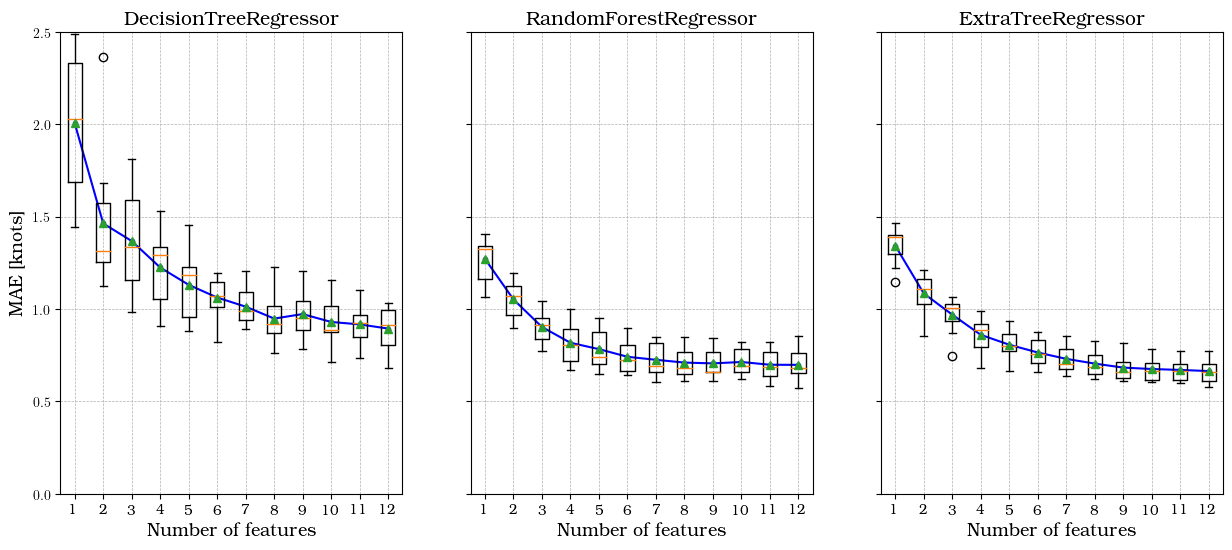

In [70]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)
plt.sca(axes[0])
feature_curve(x_test,y_test,regressor='dt',regname='DecisionTreeRegressor')
plt.sca(axes[1])
feature_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
plt.ylabel("")
plt.sca(axes[2])
feature_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
plt.ylabel("")
plt.show()

Leaf HPO

In [71]:
# Instead , we will invesitagte the effect of setting the minimal samples leaf
def leaf_curve(x,y,regressor,regname):
	from numpy import mean
	from numpy import std
	from sklearn.model_selection import cross_val_score

	plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

	# get a list of models to evaluate
	def get_models_leaf():
		models_leaf = dict()
		# define number of trees to consider
		n_samples_leaf = [1,2,3,4,5,6,7,8,9,10,50]
		for n in n_samples_leaf:
			if regressor == 'dt':
				models_leaf[str(n)] = DecisionTreeRegressor(min_samples_leaf = n)
			if regressor == 'rf':
				models_leaf[str(n)] = RandomForestRegressor(min_samples_leaf = n)
			if regressor == 'et':
				models_leaf[str(n)] = ExtraTreesRegressor(min_samples_leaf = n)
		return models_leaf

	# evaluate a given model using cross-validation
	def evaluate_model(model, x, y):
		scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)
		return -scores

	# # define dataset
	# get the models to evaluate
	models_leaf = get_models_leaf()

	# evaluate the models and store results
	results_leaf, names_leaf = list(), list()
	for name, model in models_leaf.items():
		# evaluate the model
		scores_leaf = evaluate_model(model, x, y)
		# store the results
		results_leaf.append(scores_leaf)
		names_leaf.append(name)
		# summarize the performance along the way
		print('>%s %.3f (%.3f)' % (name, mean(scores_leaf), std(scores_leaf)))


	mean_leaf = np.mean(results_leaf,axis=1)
	min_error_leaf = np.min(mean_leaf)
	print(min_error_leaf)
	bst_n_estimators_leaf = np.argmin(mean_leaf)
	print(f"The minimum MAE obtained is {min_error_leaf:.3f}")
	plt.plot(names_leaf,mean_leaf,"b.-")
	plt.grid(linestyle = '--', linewidth = 0.5)
	# plt.xlim(0,12-1)
	plt.ylim(0,2.5)
	plt.xlabel(r"Number of Samples in Leaf",fontsize=13)
	plt.ylabel(r"MAE [knots]",fontsize=13)
	plt.title(rf"{regname}", fontsize=14)
	plt.boxplot(results_leaf, labels=names_leaf,positions=range(len(names_leaf)), showmeans=True)

>1 0.911 (0.074)
>2 0.894 (0.083)
>3 0.875 (0.099)
>4 0.864 (0.076)
>5 0.861 (0.080)
>6 0.843 (0.067)
>7 0.842 (0.075)
>8 0.823 (0.088)
>9 0.827 (0.091)
>10 0.826 (0.093)
>50 0.945 (0.127)
0.8231286588574586
The minimum MAE obtained is 0.823
>1 0.697 (0.078)
>2 0.694 (0.072)
>3 0.695 (0.083)
>4 0.699 (0.091)
>5 0.710 (0.095)
>6 0.714 (0.094)
>7 0.722 (0.097)
>8 0.734 (0.105)
>9 0.740 (0.104)
>10 0.752 (0.118)
>50 1.049 (0.130)
0.6940487407672002
The minimum MAE obtained is 0.694
>1 0.656 (0.076)
>2 0.671 (0.086)
>3 0.702 (0.097)
>4 0.727 (0.090)
>5 0.766 (0.110)
>6 0.797 (0.110)
>7 0.826 (0.114)
>8 0.850 (0.124)
>9 0.868 (0.117)
>10 0.893 (0.122)
>50 1.406 (0.134)
0.6556258775563986
The minimum MAE obtained is 0.656


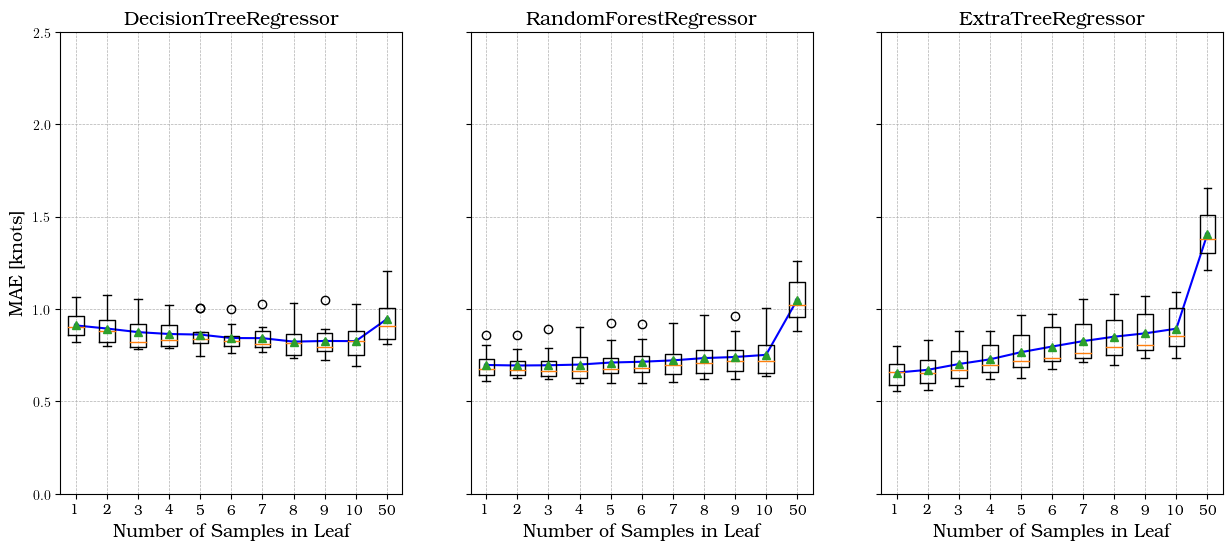

In [72]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)
plt.sca(axes[0])
leaf_curve(x_test,y_test,regressor='dt',regname='DecisionTreeRegressor')
plt.sca(axes[1])
leaf_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
plt.ylabel("")
plt.sca(axes[2])
leaf_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
plt.ylabel("")
plt.show()

Number of Trees HPO (Irrelevant for DT)

In [73]:
# explore random forest and extra tree number of trees effect on performance
def trees_curve(x,y,regressor,regname):
	from numpy import mean
	from numpy import std
	from sklearn.model_selection import cross_val_score

	plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

	# get a list of models to evaluate
	def get_models_tree():
		models_tree = dict()
		# define number of trees to consider
		n_trees = [1,10,100,200,300,400,500,600,700,800,900,1000]
		for n in n_trees:
			if regressor == 'rf':
				models_tree[str(n)] = RandomForestRegressor(n_estimators = n)
			elif regressor == 'et':
				models_tree[str(n)] = ExtraTreesRegressor(n_estimators = n)	
		return models_tree

	# evaluate a given model using cross-validation
	def evaluate_model(model_tree, x, y):
		scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)
		return -scores

	# # define dataset
	# get the models to evaluate
	models_tree = get_models_tree()

	# evaluate the models and store results
	results_tree, names_tree = list(), list()
	for name, model in models_tree.items():
		# evaluate the model
		scores_tree = evaluate_model(model, x, y)
		# store the results
		results_tree.append(scores_tree)
		names_tree.append(name)
		# summarize the performance along the way
		print('>%s %.3f (%.3f)' % (name, mean(scores_tree), std(scores_tree)))


	mean_tree = np.mean(results_tree,axis=1)
	min_error_tree = np.min(mean_tree)
	print(min_error_tree)
	print(f"The minimum MAE obtained is {min_error_tree:.3f}")
	plt.plot(names_tree,mean_tree,"b.-")
	plt.grid(linestyle = '--', linewidth = 0.5)
	# plt.xlim(0,12-1)
	plt.ylim(0,2.5)
	plt.xlabel(r"Number of Trees", fontsize=13)
	plt.ylabel(r"MAE [knots]", fontsize=13)
	plt.title(rf"{regname}", fontsize=14)
	plt.boxplot(results_tree, labels=names_tree, showmeans=True,positions=range(len(names_tree)))


>1 0.999 (0.149)
>10 0.742 (0.068)
>100 0.695 (0.067)
>200 0.691 (0.068)
>300 0.687 (0.069)
>400 0.690 (0.068)
>500 0.690 (0.070)
>600 0.691 (0.069)
>700 0.690 (0.070)
>800 0.691 (0.067)
>900 0.691 (0.070)
>1000 0.690 (0.069)
0.6865791806167835
The minimum MAE obtained is 0.687
>1 0.986 (0.105)
>10 0.717 (0.074)
>100 0.657 (0.074)
>200 0.652 (0.070)
>300 0.654 (0.072)
>400 0.655 (0.078)
>500 0.654 (0.073)
>600 0.653 (0.076)
>700 0.649 (0.075)
>800 0.651 (0.076)
>900 0.650 (0.074)
>1000 0.655 (0.075)
0.6492278646367964
The minimum MAE obtained is 0.649


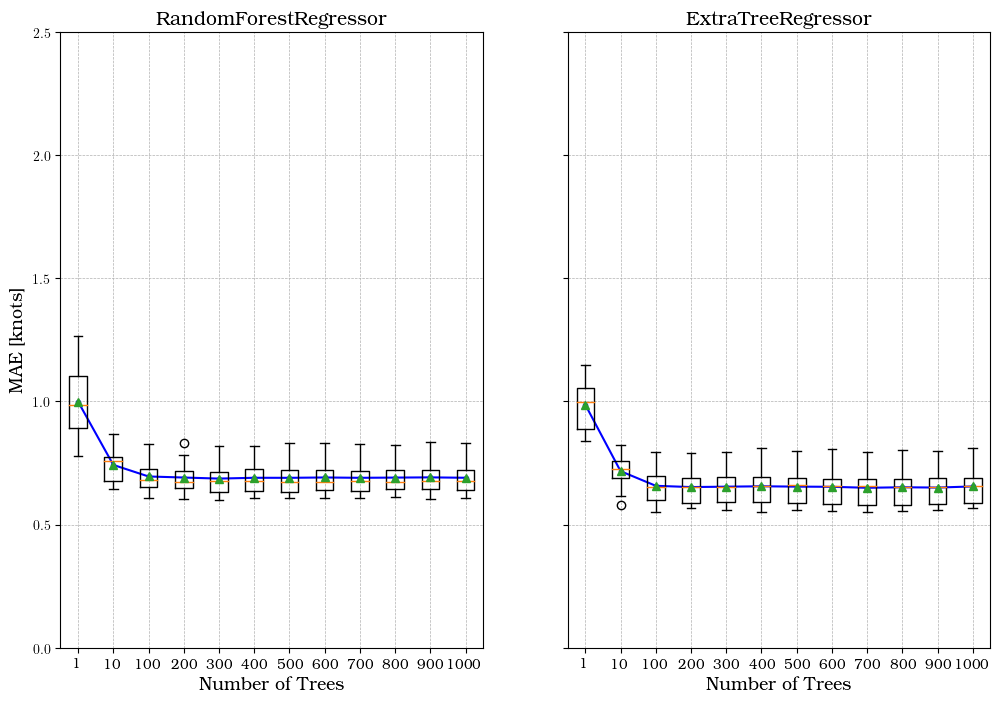

In [74]:
fig, axes = plt.subplots(ncols=2, figsize=(12,8), sharey=True)
plt.sca(axes[0])
trees_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
plt.sca(axes[1])
trees_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
plt.ylabel("")
plt.show()

Depth HPO

In [75]:
# explore tree based , tree depth. effect on performance
def depth_curve(x,y,regressor,regname):
	from numpy import mean
	from numpy import std
	from sklearn.model_selection import cross_val_score
	from sklearn.model_selection import KFold

	# Parameter to plot in nice latex font

	plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

	# get a list of models to evaluate
	def get_models_dp():
		models_dp = dict()
		# consider tree depths from 1 to 7 and None=full
		depths = [1,2,3,4,5,6,7,8,9,10,100] + [None]
		for n in depths:
			if regressor == 'dt':
				models_dp[str(n)] = DecisionTreeRegressor(max_depth=n)
			elif regressor == 'rf':
				models_dp[str(n)] = RandomForestRegressor(max_depth=n)
			elif regressor == 'et':
				models_dp[str(n)] = ExtraTreesRegressor(max_depth=n)	
		return models_dp

	# evaluate a given model using cross-validation
	def evaluate_model(model, x, y):
		# define the evaluation procedure
		cv = KFold(n_splits=10, shuffle=True, random_state=1)
		# evaluate the model and collect the results
		scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
		# negative scores due to scoring mechanism of sklearn
		return -scores

	# get the models to evaluate
	models_dp = get_models_dp()
	# evaluate the models and store results
	results_dp, names_dp = list(), list()
	for name, model in models_dp.items():
		# evaluate the model
		scores_dp = evaluate_model(model, x, y)
		# store the results
		results_dp.append(scores_dp)
		names_dp.append(name)
		# summarize the performance along the way
		print('>%s %.3f (%.3f)' % (name, mean(scores_dp), std(scores_dp)))


	mean_dp = np.mean(results_dp,axis=1)
	min_error_dp = np.min(mean_dp)
	print(min_error_dp)
	bst_n_estimators_dp= np.argmin(mean_dp)
	print(f"The minimum MAE obtained is {min_error_dp:.3f}")
	plt.plot(names_dp,mean_dp,"b.-")
	plt.grid(linestyle = '--', linewidth = 0.5)
	plt.ylim(0,2.5)
	plt.xlabel(r"Tree Depth",fontsize=13)
	plt.ylabel(r"MAE [knots]",fontsize=13)
	plt.title(rf"{regname}", fontsize=14)
	plt.boxplot(results_dp, labels=names_dp,positions=range(len(names_dp)), showmeans=True)

>1 2.052 (0.206)
>2 1.359 (0.116)
>3 1.089 (0.129)
>4 0.831 (0.107)
>5 0.781 (0.104)
>6 0.757 (0.097)
>7 0.770 (0.110)
>8 0.767 (0.089)
>9 0.797 (0.112)
>10 0.795 (0.103)
>100 0.890 (0.110)
>None 0.877 (0.098)
0.7574652055380514
The minimum MAE obtained is 0.757
>1 1.947 (0.169)
>2 1.123 (0.078)
>3 0.951 (0.108)
>4 0.789 (0.071)
>5 0.730 (0.075)
>6 0.712 (0.075)
>7 0.703 (0.078)
>8 0.698 (0.068)
>9 0.698 (0.069)
>10 0.706 (0.080)
>100 0.709 (0.079)
>None 0.705 (0.075)
0.6977983266913531
The minimum MAE obtained is 0.698
>1 2.056 (0.179)
>2 1.688 (0.156)
>3 1.346 (0.102)
>4 1.066 (0.097)
>5 0.898 (0.082)
>6 0.811 (0.085)
>7 0.747 (0.068)
>8 0.706 (0.055)
>9 0.690 (0.061)
>10 0.679 (0.062)
>100 0.659 (0.060)
>None 0.663 (0.063)
0.6593559063869161
The minimum MAE obtained is 0.659


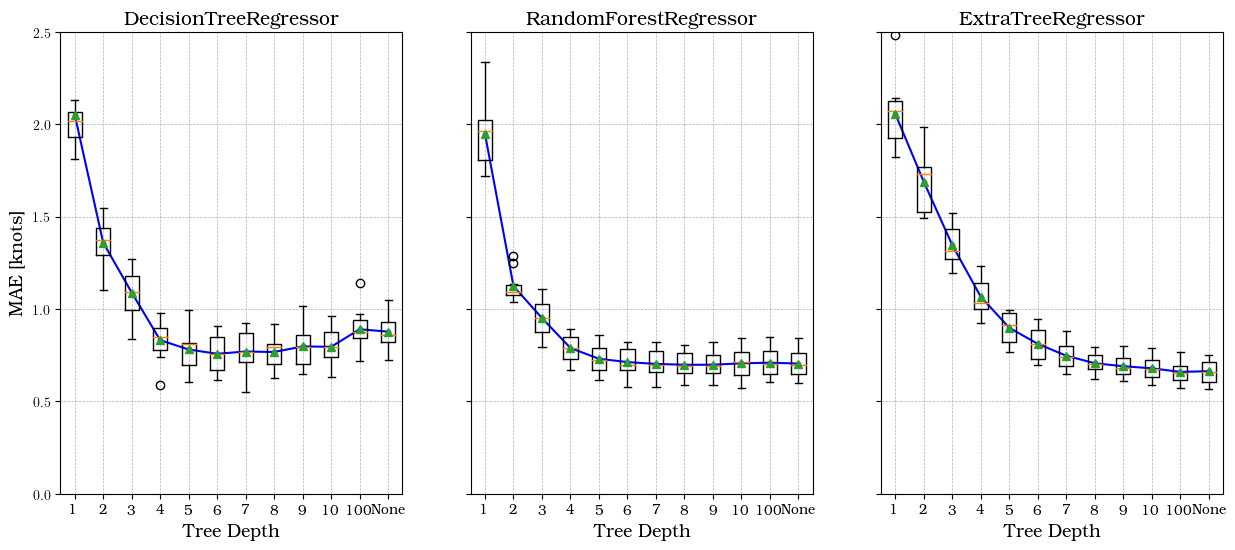

In [76]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)
plt.sca(axes[0])
depth_curve(x_test,y_test,regressor='dt',regname='DecisionTreeRegressor')
plt.sca(axes[1])
depth_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
plt.ylabel("")
plt.sca(axes[2])
depth_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
plt.ylabel("")
plt.show()

Min sample split HPO

In [77]:
# explore tree based , tree depth. effect on performance
def split_curve(x,y,regressor,regname):
	from numpy import mean
	from numpy import std
	from sklearn.model_selection import cross_val_score
	from sklearn.model_selection import KFold

	# Parameter to plot in nice latex font

	plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

	# get a list of models to evaluate
	def get_models_sp():
		models_sp = dict()
		# consider tree depths from 1 to 7 and None=full
		split = [2,3,4,5,6,7,8,9,10,20,30,40,50]
		for n in split:
			if regressor == 'dt':
				models_sp[str(n)] = DecisionTreeRegressor(min_samples_split=n)
			elif regressor == 'rf':
				models_sp[str(n)] = RandomForestRegressor(min_samples_split=n)
			elif regressor == 'et':
				models_sp[str(n)] = ExtraTreesRegressor(min_samples_split=n)	
		return models_sp

	# evaluate a given model using cross-validation
	def evaluate_model(model, x, y):
		# define the evaluation procedure
		cv = KFold(n_splits=10, shuffle=True, random_state=42)
		# evaluate the model and collect the results
		scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
		# negative scores due to scoring mechanism of sklearn
		return -scores

	# get the models to evaluate
	models_sp = get_models_sp()
	# evaluate the models and store results
	results_sp, names_sp = list(), list()
	for name, model in models_sp.items():
		# evaluate the model
		scores_sp = evaluate_model(model, x, y)
		# store the results
		results_sp.append(scores_sp)
		names_sp.append(name)
		# summarize the performance along the way
		print('>%s %.3f (%.3f)' % (name, mean(scores_sp), std(scores_sp)))


	mean_sp = np.mean(results_sp,axis=1)
	min_error_sp = np.min(mean_sp)
	print(min_error_sp)
	bst_n_estimators_sp= np.argmin(mean_sp)
	print(f"The minimum MAE obtained is {min_error_sp:.3f}")
	plt.plot(names_sp,mean_sp,"b.-")
	plt.grid(linestyle = '--', linewidth = 0.5)
	plt.ylim(0,2.5)
	plt.xlabel(r"Minimum Sample to split ",fontsize=13)
	plt.ylabel(r"MAE [knots]",fontsize=13)
	plt.title(rf"{regname}", fontsize=14)
	plt.boxplot(results_sp, labels=names_sp,positions=range(len(names_sp)), showmeans=True)

>2 0.876 (0.084)
>3 0.869 (0.065)
>4 0.891 (0.073)
>5 0.871 (0.069)
>6 0.868 (0.074)
>7 0.877 (0.079)
>8 0.863 (0.072)
>9 0.859 (0.064)
>10 0.864 (0.073)
>20 0.855 (0.078)
>30 0.854 (0.090)
>40 0.840 (0.104)
>50 0.826 (0.082)
0.8257760040498067
The minimum MAE obtained is 0.826
>2 0.700 (0.072)
>3 0.700 (0.067)
>4 0.697 (0.065)
>5 0.691 (0.067)
>6 0.698 (0.067)
>7 0.706 (0.073)
>8 0.704 (0.074)
>9 0.709 (0.076)
>10 0.708 (0.077)
>20 0.723 (0.081)
>30 0.731 (0.077)
>40 0.756 (0.073)
>50 0.779 (0.064)
0.6914925228157426
The minimum MAE obtained is 0.691
>2 0.659 (0.070)
>3 0.652 (0.072)
>4 0.656 (0.070)
>5 0.656 (0.073)
>6 0.654 (0.067)
>7 0.650 (0.064)
>8 0.655 (0.072)
>9 0.660 (0.072)
>10 0.657 (0.072)
>20 0.678 (0.063)
>30 0.701 (0.070)
>40 0.717 (0.071)
>50 0.736 (0.066)
0.6499029594404577
The minimum MAE obtained is 0.650


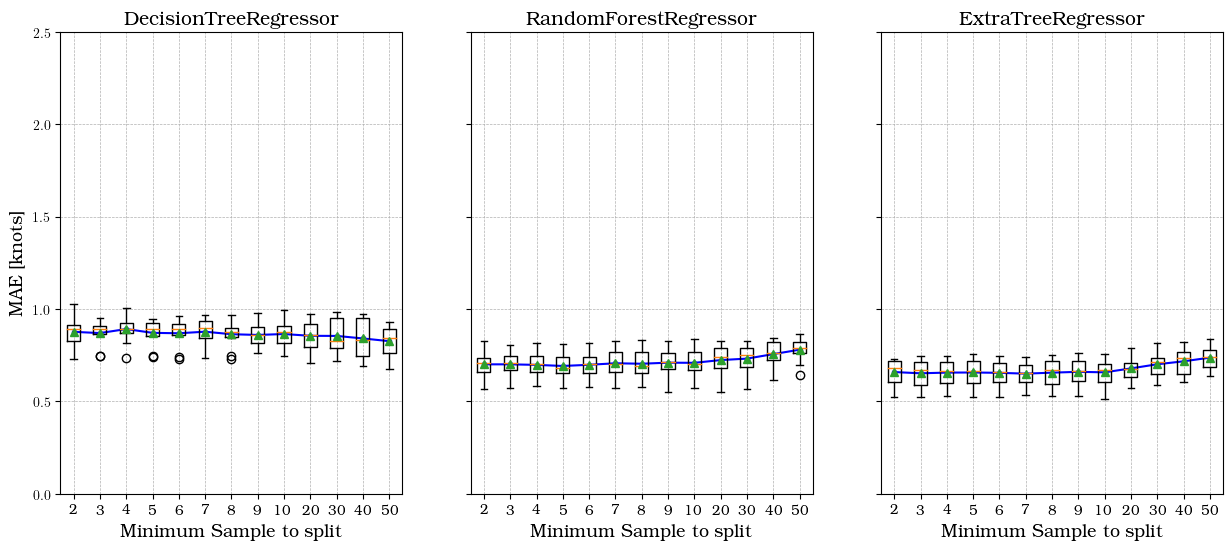

In [78]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)
plt.sca(axes[0])
split_curve(x_test,y_test,regressor='dt',regname='DecisionTreeRegressor')
plt.sca(axes[1])
split_curve(x_test,y_test,regressor='rf',regname='RandomForestRegressor')
plt.ylabel("")
plt.sca(axes[2])
split_curve(x_test,y_test,regressor='et',regname='ExtraTreeRegressor')
plt.ylabel("")
plt.show()

HP Optimisations

In [ ]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

pprint(model_rfr_ftr.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [ ]:
#from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [100,200,300,400,500,600,700,800,900,1000]
# Number of features to consider at every split
max_features = [6,7,8,9,10,11,12]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3,4,5,6,7,8,9,10]
# Method of selecting samples for training each tree
# bootstrap = [True]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
pprint(random_grid)

{'max_depth': [10,
               20,
               30,
               40,
               50,
               60,
               70,
               80,
               90,
               100,
               110,
               120,
               130,
               140,
               150,
               160,
               170,
               180,
               190,
               200,
               None],
 'max_features': [6, 7, 8, 9, 10, 11, 12],
 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model_rfr_ftr, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42,n_jobs=-1)# Fit the random search model
rf_random.fit(x_test, y_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110, 120,
                                                      130, 140, 150, 160, 170,
                                                      180, 190, 200, None],
                                        'max_features': [6, 7, 8, 9, 10, 11,
                                                         12],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=2)

In [ ]:
#optimal parameters
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 10,
 'max_depth': 120}

HPO for DTR test data

In [ ]:
# Number of trees in random forest
# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# Maximum number of levels in tree
max_depth = [1,2,3,4,5,6,7,8,9,10,100]
max_depth.append(None)
# max_depth = [None]
# Minimum number of samples required to split a node
min_samples_split = [2,3,4,5,6,7,8,9,10,15,20,30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,3,4,5,6,7,8,9,10]
random_grid_dtr = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}
pprint(random_grid_dtr)

{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, None],
 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12],
 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]}


In [ ]:
dt_random = RandomizedSearchCV(estimator = model_dtr, param_distributions = random_grid_dtr, n_iter = 100, cv = 10, verbose=2, random_state=42,n_jobs=-1)# Fit the dt search model
dt_random.fit(x_test, y_test)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 100, None],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 12],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 15, 20,
                                                              30]},
                   random_state=42, verbose=2)

In [ ]:
#optimal parameters
dt_random.best_params_

{'min_samples_split': 2,
 'min_samples_leaf': 6,
 'max_features': 10,
 'max_depth': 5}

ETR

In [ ]:
from pprint import pprint
pprint(model_etr.get_params())

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [100,200,300,400,500,600,700,800,900,1000]
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1,2,3,4,5,6,7,8,9,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3,4,5,6,7,8,9,10]
# Method of selecting samples for training each tree
# bootstrap = [True]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
               #'bootstrap': bootstrap}
pprint(random_grid)

{'max_depth': [10,
               20,
               30,
               40,
               50,
               60,
               70,
               80,
               90,
               100,
               110,
               120,
               130,
               140,
               150,
               160,
               170,
               180,
               190,
               200,
               None],
 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12],
 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [ ]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
et_random = RandomizedSearchCV(estimator = model_etr, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=1,n_jobs=-1)# Fit the random search model
et_random.fit(x_test, y_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\Wafi\anaconda3\envs\geron1\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
75 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Wafi\anaconda3\envs\geron1\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Wafi\anaconda3\envs\geron1\lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "c:\Users\Wafi\anaconda3\envs\geron1\lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  Fi

RandomizedSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110, 120,
                                                      130, 140, 150, 160, 170,
                                                      180, 190, 200, None],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 12],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=1, verbose=2)

In [ ]:
#optimal parameters
et_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 9,
 'min_samples_leaf': 1,
 'max_features': 12,
 'max_depth': 120}